# Satellite Imagery

In [1]:
!pip install patchify tensorflow

In [2]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset_root_folder = '/content/drive/MyDrive/datasets/'

In [5]:
dataset_name = 'DubaiSatelliteDataset'

In [6]:
minmaxscaler = MinMaxScaler()

In [7]:
for path, subdirs, files in os.walk(os.path.join(dataset_root_folder, dataset_name)):
  dir_name = path.split(os.path.sep)[-1]
  # print(dir_name)
  if dir_name == "masks":  # masks
    images = os.listdir(path)
    print(path)
    for i, image_name in enumerate(images):
      if (image_name.endswith('.png')):     # .png for masks
        # print(image_name)
        a = True

/content/drive/MyDrive/datasets/DubaiSatelliteDataset/Tile 3/masks
/content/drive/MyDrive/datasets/DubaiSatelliteDataset/Tile 1/masks
/content/drive/MyDrive/datasets/DubaiSatelliteDataset/Tile 5/masks
/content/drive/MyDrive/datasets/DubaiSatelliteDataset/Tile 2/masks
/content/drive/MyDrive/datasets/DubaiSatelliteDataset/Tile 8/masks
/content/drive/MyDrive/datasets/DubaiSatelliteDataset/Tile 6/masks
/content/drive/MyDrive/datasets/DubaiSatelliteDataset/Tile 7/masks
/content/drive/MyDrive/datasets/DubaiSatelliteDataset/Tile 4/masks


In [8]:
image_patch_size = 256

In [9]:
image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 2/images/image_part_001.jpg', 1)

In [10]:
image.shape

(544, 509, 3)

## Satellite Image Pre-processing

In [11]:
 image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)


In [12]:
# validating ingestion
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [13]:
print(len(image_dataset))
print(len(mask_dataset))


945
945


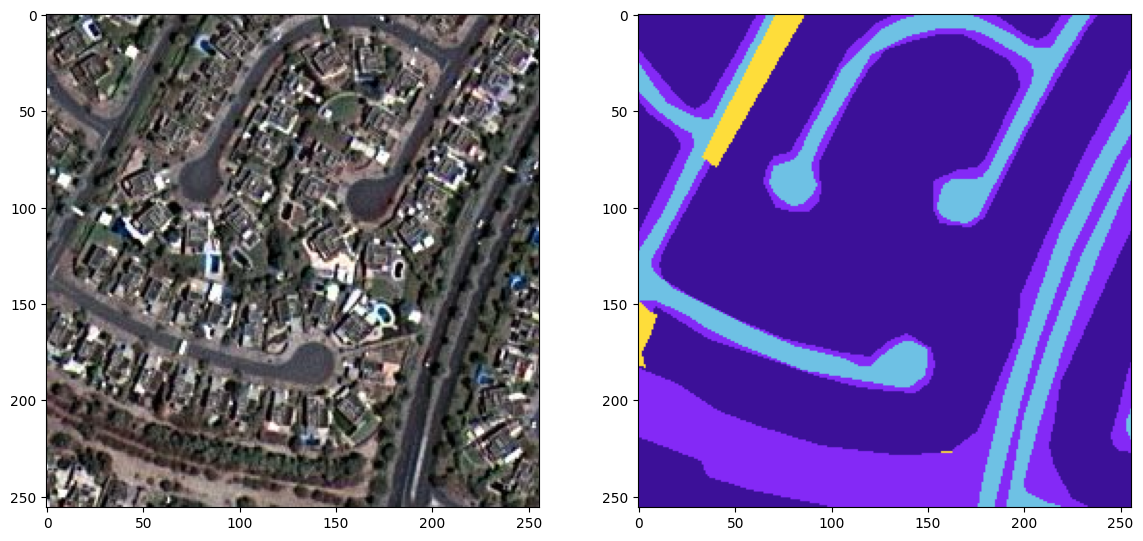

In [14]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize = (14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [15]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [16]:
mask_dataset.shape[0]

945

In [17]:
label = individual_patched_mask

In [18]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  label_segment = label_segment[:,:,0]
  return label_segment

In [19]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)


In [20]:
print(len(labels))

945


In [21]:
labels = np.array(labels)

array([[1, 5, 5, ..., 0, 0, 0],
       [1, 5, 5, ..., 0, 0, 0],
       [1, 1, 5, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2]], dtype=uint8)
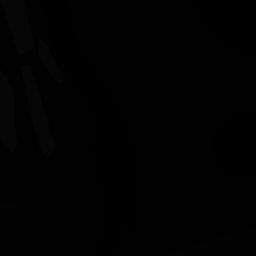

In [22]:
labels[1]

In [23]:
labels = np.expand_dims(labels, axis=3)

In [24]:
labels[0]

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]], dtype=uint8)

In [25]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [26]:
print("Total unique labels based on masks: ", format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


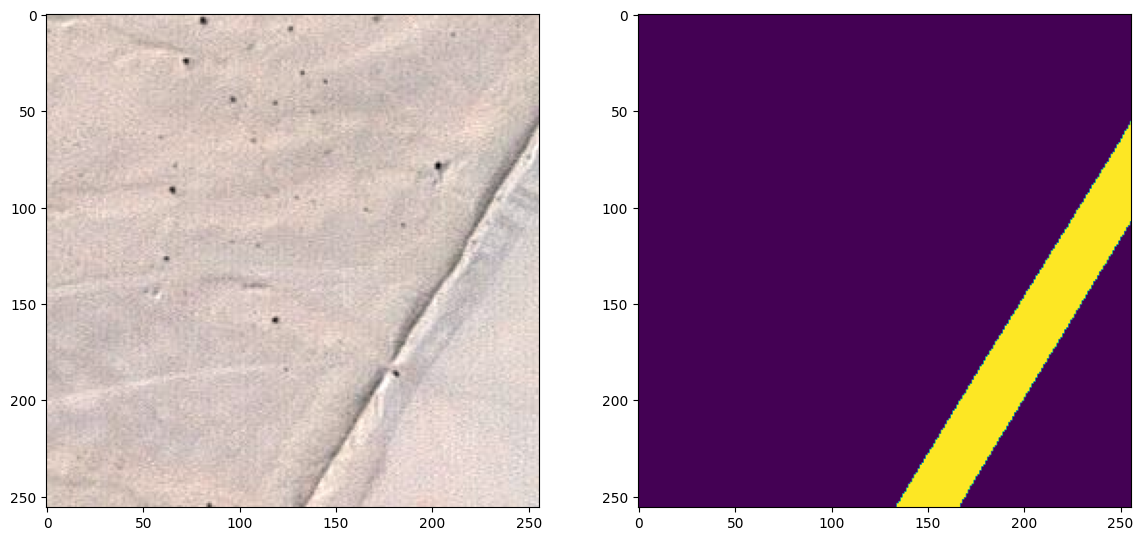

In [27]:
# render output based on labels
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize = (14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(labels[random_image_id][:,:, 0])

## Training and Test sets

In [28]:
total_classes = len(np.unique(labels))

In [29]:
total_classes

6

In [30]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [31]:
labels_categorical_dataset.shape

(945, 256, 256, 6)

In [32]:
master_training_dataset = image_dataset

In [33]:
master_training_dataset.shape

(945, 256, 256, 3)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size=0.15, random_state=42)

In [35]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [36]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [37]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6
